In [1]:
import os
import numpy as np
import sklearn
import pandas as pd
import pickle

In [2]:
# #Initializing file paths
raw_dir = os.path.join(os.pardir,os.pardir,'data','raw')
processed_dir = os.path.join(os.pardir,os.pardir,'data','processed')
model_dir = os.path.join(os.pardir,os.pardir,'models')

In [32]:
# train_path = "https://worksheets.codalab.org/rest/bundles/0x7b873062afd04a7f82a7a49940ee7737/contents/blob/" #'../../data/raw/train.csv'
# val_path = "https://worksheets.codalab.org/rest/bundles/0xa63401efaa6d44e39ed6ed9fe7e08cd2/contents/blob/"#'../../data/raw/dev.csv'
# test_path = "https://worksheets.codalab.org/rest/bundles/0xbb4a5897ea4b456fb7a6bd81289d1fbc/contents/blob/"

train_path = os.path.join(raw_dir,'train.csv')
val_path = os.path.join(raw_dir, 'dev.csv')
test_path = os.path.join(raw_dir, 'test_no_label.csv')

train = pd.read_csv(train_path)
validation = pd.read_csv(val_path)
test = pd.read_csv(test_path)

In [4]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


In [5]:
validation.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,11,934,0,5.0,1,2014-01-20,"all around good place, cozy, I came in and did..."
1,17,940,0,4.0,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich..."
2,20,943,0,5.0,0,2014-05-24,Some good Big Greek cooking!! Came to City on ...
3,30,953,0,4.0,0,2013-10-17,So... as you may notice from some of my other ...
4,43,966,0,3.0,0,2012-12-19,"I don't understand the whole ""You can't order ..."


In [6]:
seed = 10

In [7]:
positive_examples = train[train['label']==1]

# Setting frac = 1 to shuffle all the data
negative_examples = train[train['label']==0]

In [8]:
# Sampling thesame size of date in positive class from the negative class
sampled_negative_examples = negative_examples.sample(n=positive_examples.shape[0],random_state=seed)

In [9]:
# balanced data
balanced_df = pd.concat([sampled_negative_examples, positive_examples])
# balanced_df.head()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# Balanced data
bal_cnt_vectorizer = CountVectorizer(stop_words='english', binary=True)
bal_tfidf_vectorizer = TfidfVectorizer(stop_words='english', binary=True)
bal_cnt_vectorizer.fit(balanced_df['review'])
bal_tfidf_vectorizer.fit(balanced_df['review'])

bal_cnt_X_train = bal_cnt_vectorizer.transform(balanced_df['review'])
bal_tfidf_X_train = bal_tfidf_vectorizer.transform(balanced_df['review'])

bal_cnt_X_dev = bal_cnt_vectorizer.transform(validation['review'])
bal_tfidf_X_dev = bal_tfidf_vectorizer.transform(validation['review'])

bal_Y_train = balanced_df['label']
bal_Y_dev = validation['label']

In [12]:
from sklearn.naive_bayes import MultinomialNB 

In [13]:
tfidf_nb = MultinomialNB()
cnt_nb = MultinomialNB()

In [14]:
tfidf_nb = tfidf_nb.fit(bal_tfidf_X_train,bal_Y_train)
cnt_nb = cnt_nb.fit(bal_cnt_X_train, bal_Y_train)

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

In [41]:
def ClassifierMetrics (X_train, Y_train, X_test, Y_test, fitted_model):
    """
    X_train: training set features
    Y_train: training set labels
    X_test: dev/test set features
    Y_test: dev/test set labels
    fitted_model: 
    """
    Y_pred = fitted_model.predict(X_test)
    Y_score = fitted_model.predict_proba(X_test)[:,1]
    metrics = {'train_accuracy': fitted_model.score(X_train, Y_train),
               'test_accuracy': fitted_model.score(X_test, Y_test),
               'test_auc_pred': roc_auc_score(Y_test, Y_pred),
               'test_auc_score': roc_auc_score(Y_test, Y_score),
               'test_ap_pred': average_precision_score(Y_test, Y_pred),
               'test_ap_score': average_precision_score(Y_test, Y_score)}
    return metrics, Y_pred, Y_score

In [42]:
bal_tfidf_metrics, bal_tfidf_pred, bal_tfidf_proba = ClassifierMetrics (bal_tfidf_X_train, bal_Y_train, bal_tfidf_X_dev, bal_Y_dev, tfidf_nb)
bal_cnt_metrics, bal_cnt_pred, bal_cnt_proba = ClassifierMetrics (bal_cnt_X_train, bal_Y_train, bal_cnt_X_dev, bal_Y_dev, cnt_nb)


In [43]:
bal_tfidf_metrics

{'train_accuracy': 0.7400557728804369,
 'test_accuracy': 0.7207528258811737,
 'test_auc_pred': 0.648990978327054,
 'test_auc_score': 0.7144035437699455,
 'test_ap_pred': 0.15375167463546943,
 'test_ap_score': 0.21035409495131602}

In [44]:
bal_cnt_metrics

{'train_accuracy': 0.7288624656260894,
 'test_accuracy': 0.635419566791024,
 'test_auc_pred': 0.6536533511109663,
 'test_auc_score': 0.7025597523159852,
 'test_ap_pred': 0.14894025361252883,
 'test_ap_score': 0.19178368956525937}

In [20]:
# Unbalanced data
unbal_cnt_vectorizer = CountVectorizer(stop_words='english', binary=True)
unbal_tfidf_vectorizer = TfidfVectorizer(stop_words='english', binary=True)
unbal_cnt_vectorizer.fit(train['review'])
unbal_tfidf_vectorizer.fit(train['review'])

unbal_cnt_X_train = unbal_cnt_vectorizer.transform(train['review'])
unbal_tfidf_X_train = unbal_tfidf_vectorizer.transform(train['review'])

unbal_cnt_X_dev = unbal_cnt_vectorizer.transform(validation['review'])
unbal_tfidf_X_dev = unbal_tfidf_vectorizer.transform(validation['review'])

unbal_Y_train = train['label']
unbal_Y_dev = validation['label']

In [21]:
unbal_tfidf_nb = MultinomialNB()
unbal_cnt_nb = MultinomialNB()

In [24]:
unbal_tfidf_nb = unbal_tfidf_nb.fit(unbal_tfidf_X_train,unbal_Y_train)
unbal_cnt_nb = unbal_cnt_nb.fit(unbal_cnt_X_train,unbal_Y_train)

In [47]:
unbal_tfidf_metrics, unbal_tfidf_pred, unbal_tfidf_proba = ClassifierMetrics (unbal_tfidf_X_train, unbal_Y_train, unbal_tfidf_X_dev, unbal_Y_dev, unbal_tfidf_nb)
unbal_cnt_metrics, unbal_cnt_pred, unbal_cnt_proba = ClassifierMetrics (unbal_cnt_X_train, unbal_Y_train, unbal_cnt_X_dev, unbal_Y_dev, unbal_cnt_nb)


In [48]:
unbal_tfidf_metrics

{'train_accuracy': 0.8977016350837472,
 'test_accuracy': 0.8986023720697144,
 'test_auc_pred': 0.5014302041029907,
 'test_auc_score': 0.689892929857181,
 'test_ap_pred': 0.10333147568920387,
 'test_ap_score': 0.1917596315519445}

In [49]:
unbal_cnt_metrics

{'train_accuracy': 0.8841968478200212,
 'test_accuracy': 0.8778606826660728,
 'test_auc_pred': 0.5340158456064239,
 'test_auc_score': 0.7142021480286943,
 'test_ap_pred': 0.11693767838845275,
 'test_ap_score': 0.20503222127962936}

In [50]:
 MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

In [100]:
def get_best_param(X_train,y_train,X_val,y_val,alphas):
    results = {}
    a,b = 0,1
    for alpha in alphas:
        model_true = MultinomialNB(alpha=alpha, fit_prior=True)
        model_false = MultinomialNB(alpha=alpha, fit_prior=False)
        
        model_true = model_true.fit(X_train,y_train)
        model_false = model_false.fit(X_train,y_train)
        
        model_true_metrics, _, _ = ClassifierMetrics (X_train, y_train, X_val, y_val, model_true)
        model_false_metrics, _, _ = ClassifierMetrics (X_train, y_train, X_val, y_val, model_false)
        
        model_true_metrics['fit_prior'] = True
        model_false_metrics['fit_prior'] = False
        
        model_true_metrics['alpha'] = alpha
        model_false_metrics['alpha'] = alpha
        
        results[a] = model_true_metrics
        results[b] = model_false_metrics
        
        a = a+2
        b = b+2
        
    return results

In [124]:
# balanced dataset
alpha_vals = [0.1, 0.5, 1.0,1.2,1.4,1.6,1.7,1.8,2.0,2.5,3.0,4.0]

bal_results = get_best_param(bal_tfidf_X_train,bal_Y_train,bal_tfidf_X_dev,bal_Y_dev,alpha_vals)

bal_results = pd.DataFrame(bal_results).T
bal_results

,alpha,class_prior,test_accuracy,test_ap_pred,test_ap_score,test_auc_pred,test_auc_score,train_accuracy
0,0.1,True,0.650788,0.145583,0.19897,0.643242,0.696561,0.791568
1,0.1,False,0.650788,0.145583,0.19897,0.643242,0.696561,0.791568
2,0.5,True,0.683306,0.151064,0.207749,0.650763,0.70966,0.760448
3,0.5,False,0.683306,0.151064,0.207749,0.650763,0.70966,0.760448
4,1,True,0.720753,0.153752,0.210354,0.648991,0.714404,0.740056
5,1,False,0.720753,0.153752,0.210354,0.648991,0.714404,0.740056
6,1.2,True,0.733448,0.154547,0.210838,0.647668,0.715455,0.733084
7,1.2,False,0.733448,0.154547,0.210838,0.647668,0.715455,0.733084
8,1.4,True,0.744724,0.156245,0.211237,0.64823,0.71627,0.72741
9,1.4,False,0.744724,0.156245,0.211237,0.64823,0.71627,0.72741


In [125]:
import matplotlib.pyplot as plt

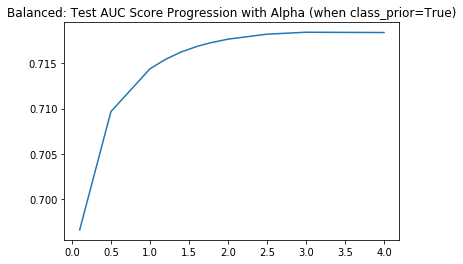

In [126]:
plt.plot(bal_results[bal_results.class_prior==True].alpha, bal_results[bal_results.class_prior==True].test_auc_score)
plt.title("Balanced: Test AUC Score Progression with Alpha (when fit_prior=True)")
plt.show()

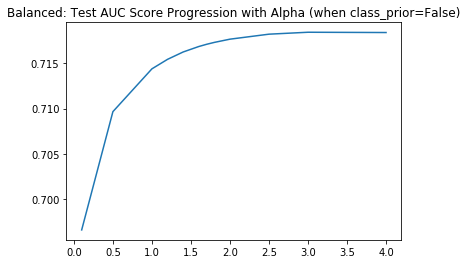

In [127]:
plt.plot(bal_results[bal_results.class_prior==False].alpha, bal_results[bal_results.class_prior==False].test_auc_score)
plt.title("Balanced: Test AUC Score Progression with Alpha (when fit_prior=False)")
plt.show()

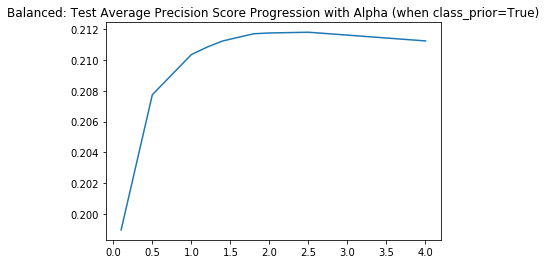

In [128]:
plt.plot(bal_results[bal_results.class_prior==True].alpha, bal_results[bal_results.class_prior==True].test_ap_score)
plt.title("Balanced: Test Average Precision Score Progression with Alpha (when fit_prior=True)")
plt.show()

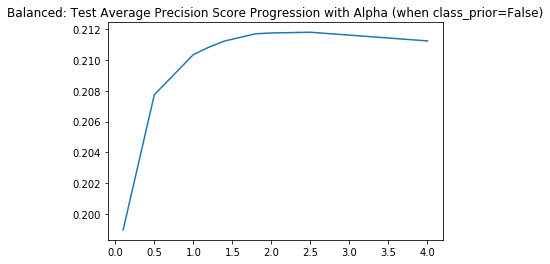

In [129]:
plt.plot(bal_results[bal_results.class_prior==False].alpha, bal_results[bal_results.class_prior==False].test_ap_score)
plt.title("Balanced: Test Average Precision Score Progression with Alpha (when fit_prior=False)")
plt.show()

In [130]:
# Unbalanced data
unbal_results = get_best_param(unbal_tfidf_X_train,unbal_Y_train,unbal_tfidf_X_dev,unbal_Y_dev,alpha_vals)

unbal_results = pd.DataFrame(unbal_results).T
unbal_results

,alpha,class_prior,test_accuracy,test_ap_pred,test_ap_score,test_auc_pred,test_auc_score,train_accuracy
0,0.1,True,0.898742,0.106074,0.206872,0.504182,0.706792,0.904414
1,0.1,False,0.757253,0.149873,0.206872,0.632348,0.706792,0.786243
2,0.5,True,0.898714,0.10448,0.198208,0.502343,0.701042,0.898714
3,0.5,False,0.872237,0.120447,0.198208,0.542192,0.701042,0.878345
4,1,True,0.898602,0.103331,0.19176,0.50143,0.689893,0.897702
5,1,False,0.891392,0.108622,0.19176,0.514437,0.689893,0.892468
6,1.2,True,0.89863,0.10347,0.189952,0.501446,0.686633,0.897574
7,1.2,False,0.893396,0.106371,0.189952,0.50996,0.686633,0.894313
8,1.4,True,0.89863,0.10347,0.18848,0.501446,0.6839,0.89751
9,1.4,False,0.894816,0.105306,0.18848,0.50759,0.6839,0.895354


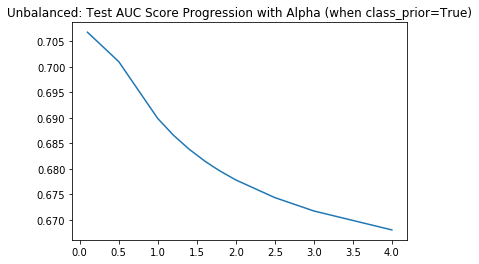

In [131]:
plt.plot(unbal_results[unbal_results.class_prior==True].alpha, unbal_results[unbal_results.class_prior==True].test_auc_score)

plt.title("Unbalanced: Test AUC Score Progression with Alpha (when fit_prior=True)")
plt.show()

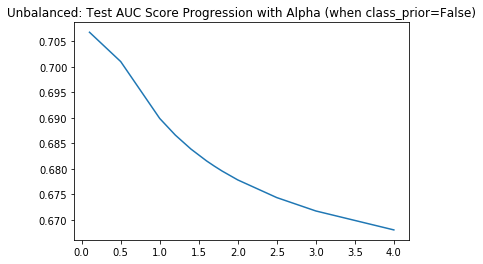

In [132]:
plt.plot(unbal_results[unbal_results.class_prior==False].alpha, unbal_results[unbal_results.class_prior==False].test_auc_score)
plt.title("Unbalanced: Test AUC Score Progression with Alpha (when fit_prior=False)")
plt.show()

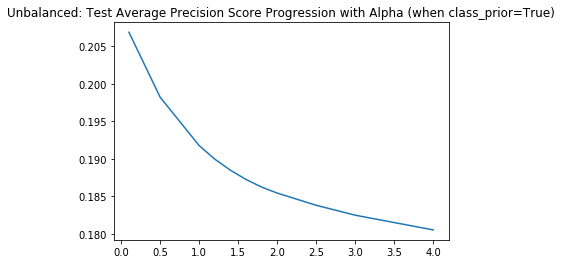

In [133]:
plt.plot(unbal_results[unbal_results.class_prior==True].alpha, unbal_results[unbal_results.class_prior==True].test_ap_score)
plt.title("Unbalanced: Test Average Precision Score Progression with Alpha (when fit_prior=True)")
plt.show()

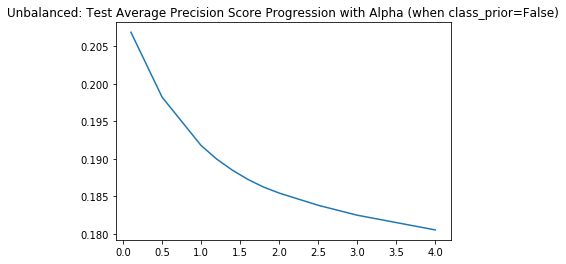

In [134]:
plt.plot(unbal_results[unbal_results.class_prior==False].alpha, unbal_results[unbal_results.class_prior==False].test_ap_score)
plt.title("Unbalanced: Test Average Precision Score Progression with Alpha (when fit_prior=False)")
plt.show()

In [136]:
# Training using best hyperparameter alpha=2.5 class_prior=True
model = MultinomialNB(alpha=2.5, fit_prior=True)

model = model.fit(bal_tfidf_X_train, bal_Y_train)

In [82]:
test.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,6,929,0,4.0,NaN,2009-08-25,Let me start with a shout-out to everyone who ...
1,9,932,0,5.0,NaN,2014-05-09,Stopped in for lunch today and couldn't believ...
2,14,937,0,4.0,NaN,2014-10-15,"Tiny little place, but very good food. Pastits..."
3,22,945,0,5.0,NaN,2014-04-10,Food was delicious and service was great. Good...
4,23,946,0,5.0,NaN,2014-03-29,Awesome hole in the wall place to grab a quick...


In [137]:
# Inference on test using best model

test_tfidf_X_train = bal_tfidf_vectorizer.transform(test['review'])

In [139]:
test_proba = model.predict_proba(test_tfidf_X_train)[:,1]

In [142]:
test_proba_df = pd.DataFrame(test_proba,columns=['label'])
test_proba_df.head()

,label
0,0.201258
1,0.447258
2,0.495282
3,0.529838
4,0.419443


In [145]:
test_proba_df.to_csv(os.path.join(processed_dir,'test_predictions_ece278.csv'))